<a href="https://colab.research.google.com/github/No-Qubit-Left-Behind/NQLB/blob/master/TwoQubitGate/Adiabatic_CZ_Gaussian_MagPhase.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Two qubit gate: Adiabatic CZ
- Rao2014 adiabatic CZ gate (Zhang2020 experimental)
- using intermediate state of $6P_{3/2}$ to Rydberg

In [1]:
!pip install ARC-Alkali-Rydberg-Calculator
!pip install qutip

     |████████████████████████████████| 26.5MB 114kB/s 
     |████████████████████████████████| 266kB 54.6MB/s 
     |████████████████████████████████| 61kB 10.2MB/s 
     |████████████████████████████████| 256kB 58.1MB/s 
  Created wheel for ARC-Alkali-Rydberg-Calculator: filename=ARC_Alkali_Rydberg_Calculator-3.0.4-cp36-cp36m-linux_x86_64.whl size=27215707 sha256=d7820afcbe7741b8570b6955d959784b8a3cf02c30e649b0a83d95cb3d1e271a
  Stored in directory: /root/.cache/pip/wheels/26/07/af/fc340419c62c1b13593c8c4e128153b87302692684a54df3c1
  Created wheel for lmfit: filename=lmfit-1.0.1-cp36-none-any.whl size=81990 sha256=d564ca086fa76cde7fd1149097e354d53428ee7db16f663529238301b8aea0fb
  Stored in directory: /root/.cache/pip/wheels/ef/22/8d/6cd9c0af36f501cfb248673b05dad5d2c27504951d55519acb
  Created wheel for asteval: filename=asteval-0.9.18-cp36-none-any.whl size=17381 sha256=116dc35ec10f84774847c62668338d8831eac9bd4d51ade945d3132503c261bf
  Stored in directory: /root/.cache/pip/wheels/1c/

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
%tensorflow_version 2.x
import tensorflow as tf
import numpy as np
import time
from arc import *
from qutip import *
import matplotlib.pyplot as plt
import scipy.signal as sp_signal

print(tf.__version__)

2.3.0


In [164]:
#Plot settings:
#set math font:
plt.rcParams["axes.linewidth"] = 2
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['ytick.major.size'] = 5
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12) 

plt.rcParams.update({'font.size': 15})

######Set all systm parameters: (using ARC)
GHz = 1E9
MHz = 1E6 
kHz = 1E3

ms = 1E-3
us = 1E-6
ns = 1E-9

atom=Rubidium()

##1. Intermediate excited state: 6P3/2
n_i = 6
l_i = 1
j_i = 1.5
T_i = atom.getStateLifetime(n_i,l_i,j_i)
Gamma_i = 1/T_i #Decay rate of intermediate state

Gamma_i1 = 1 * Gamma_i #Intermeidate state is F=3, and 1 is F=2
Gamma_i0 = 0 * Gamma_i #Intermeidate state is F=3, and 0 is F=1 (forbidden)

##2. Decay between hyperfine ground states
Gamma_10 = 2*np.pi * 10 # 10 Hz

##3. Rydberg state: 70 S1/2
n_r = 70
l_r = 0
j_r = 0.5
#Total lifetime: Accounting for blackbody stimulation of Rydberg state to nearby states: (see Levin2018)
#Total lifetime is blackbody plus radiative: 1/T_rtotal = 1/T_rBB + 1/T_rRadiative
T_rTot = atom.getStateLifetime(n_r,l_r,j_r, temperature= 300, includeLevelsUpTo = n_r + 20) 
#Radiative lifetime: decay to other ground state (so at 0 K temp)
T_rRad = atom.getStateLifetime(n_r,l_r,j_r, temperature= 0) 

T_ri = 1/atom.getTransitionRate(n_r,l_r,j_r, n_i,l_i,j_i, temperature=0) #radiative transition from rydberg to intermediate
T_rgp = 1/(1/T_rRad - 1/T_ri) #radiative transition from rydberg to dark ground states

#Black body stimulated: Transition from rydberg to nearby rydberg
T_rBB = 1/(1/T_rTot - 1/T_rRad)

#Set decay rate to each state
Gamma_ri = 1/T_ri
Gamma_rrp = 1/T_rBB # r to r' (r prime)
Gamma_rgp = 1/T_rgp #rydberg to g' (ground prime dark states)
Gamma_rTot = Gamma_ri + Gamma_rrp + Gamma_rgp #Total decay from Rydberg
Gamma_rd = Gamma_rrp + Gamma_rgp

Gammas = [Gamma_10, Gamma_i1, Gamma_ri, Gamma_rd]

######Parameters level :######################

##Set system parameters: (from chapter 7 DeLeseleuc)
Rabi_i = 2*np.pi * 174 * MHz #coupling state 1 to i
Rabi_r = 2*np.pi * 115 * MHz #coupling state i to r

##Set detunings
Delta_i = 2*np.pi * 150 * MHz  #Max detuning
del_total = 0

#Set interaction strength:
V_int = 2 * np.pi * 24 * MHz #From Omran paper

##Set time grid:
t_0 = 0 #Initial time
t_f = 300 * ns #Final time of first 
nt = 1000 #number of time points
pad = 30 #set number of padding points (for zeroes during pulse)
delta_t = (t_f - t_0)/nt #time difference between steps
tlist = np.linspace(0, t_f, nt + 2 * pad)

#Set bandwidth of pulse: sets largest frequency component in pulse
f_std = 0.1 * GHz # (using 10 ns rise time)

#Set number of basis functions for the control amplitudes
input_dim = 10 #(number of Gaussian modes)

#Set number of iterations in the optimization:
num_iters = 1000
#Set learn rate for optimizer:
learn_rate = 0.01

# Class Propagator

In [165]:
class PropagatorVL:
    def __init__(
        self, input_dim, no_of_steps, pad, f_std, delta_t, del_total, V_int, \
        Delta_i, Rabi_i, Rabi_r, Gammas_all
        ):
        self.duration = no_of_steps * delta_t
        self.delta_t = delta_t
        self.Vint = V_int
        self.Rabi_i = Rabi_i #Set maximum control amplitude
        self.Rabi_r = Rabi_r #Set maximum control amplitude
        self.Delta_i = Delta_i #Set maximum control amplitude
        self.del_total = del_total
        self.Gamma_10, self.Gamma_i1, self.Gamma_ri, self.Gamma_rd = Gammas_all
        self.dim = 4 #Dimension of each atom
        self.input_dim = input_dim
        self.no_of_steps = no_of_steps
        """ generate a Gaussian filter array (in frequency domain) """
        self.padding = pad #sets extra number of points on either side of pulse
        self.freqs = np.fft.fftfreq(no_of_steps, d=delta_t) #set frequency spectrum
        self.std = f_std/(self.freqs[1] - self.freqs[0]) #Set standard deviation of Gaussian filter
        self.Gaussian_filter = tf.constant(
            sp_signal.gaussian(no_of_steps + 2 * self.padding, self.std),
            dtype = tf.complex128
        )
        """
        Set initial and final states and target gate
        """ 
        g_0, g_1, i, r = self.nLevelAtomBasis(self.dim) # basis per atom
        self.psi_pp = tf.cast(1/2 * (
            tensor(g_0, g_0) + tensor(g_0, g_1) + \
            tensor(g_1, g_0) + tensor(g_1, g_1)
        ), dtype = tf.complex128)

        self.psi_10 = tf.cast(tensor(g_1, g_0), dtype = tf.complex128)
        self.psi_11 = tf.cast(tensor(g_1, g_1), dtype = tf.complex128)

        self.U_target = tensor(g_0, g_0) * tensor(g_0, g_0).dag() \
                + tensor(g_0, g_1) * tensor(g_0, g_1).dag() \
                + tensor(g_1, g_0) * tensor(g_1, g_0).dag() \
                - tensor(g_1, g_1) * tensor(g_1, g_1).dag()
        """
        Set up Van Loan generators
        """
        Ham_args = [g_0, g_1, i, r, self.dim, self.del_total, self.Vint,
        self.Delta_i, self.Rabi_i, self.Rabi_r, self.Gamma_10,
        self.Gamma_i1, self.Gamma_ri, self.Gamma_rd]
        basis = [g_0, g_1, i, r]
        self.VL_Generators_ansatz = self.VL_Generators(
            self.Hamiltonian(Ham_args), basis, self.dim
        )

        """
        Number of control amplitudes: global for both atoms
        (Delta_i, mag Rabi_i, phase Rabi_r, mag Rabi_i, phase Rabi_r)
        """
        self.num_ctrls = 5
        """
            There are 5 control amplitudes in order:
            Delta_i, Rabi_i amplitude, Rabi_i phase, 
            Rabi_r amplitude, Rabi_r phase,
        """
        # Gaussian amplitudes:
        self.ctrl_amplitudes_a = tf.Variable(
            tf.zeros([input_dim, self.num_ctrls], dtype=tf.float64
                     ), dtype=tf.float64
        )
        # Gaussian centers:
        self.ctrl_amplitudes_b = tf.Variable(
            tf.zeros([input_dim, self.num_ctrls], dtype=tf.float64
                     ), dtype=tf.float64
        )
        # Gaussian STD:
        self.ctrl_amplitudes_c = tf.Variable(
            tf.zeros([input_dim, self.num_ctrls], dtype=tf.float64
                     ), dtype=tf.float64
        )
        #All control amplitudes together
        self.ctrl_amplitudes_all = tf.concat(
                [self.ctrl_amplitudes_a, self.ctrl_amplitudes_b,
                self.ctrl_amplitudes_c], 1
        )

        """
            self.contraction_array determines the neccessity for the extra
            matrix multiplication step in the recursive method self.propagate()
            when the intermediate computation array has length not divisible
            by 2
        """
        self.contraction_array = self.gen_contraction_array(
            no_of_steps + 2 * self.padding
        )

    @staticmethod
    def gen_contraction_array(no_of_intervals):
        if no_of_intervals > 1:
            return (
                [bool(np.mod(no_of_intervals, 2))] +
                PropagatorVL.gen_contraction_array(
                    np.floor(no_of_intervals / 2)
                )
            )
        return []  

        """
            nLevelAtomBasis creates a basis set for an n level atom as qutip
            quantum objects
        """
    @staticmethod
    def nLevelAtomBasis(n):
        states = []
        for n_l in range(0,n):
            states.append(qutip.basis(n, n_l))
        return np.array(states, dtype=object)

    @staticmethod
    def Hamiltonian(args):
        """Ladder-system Hamiltonian: Outputs a Qutip quantum object"""
        #Set 5 level sysem operators: includes dark ground and Rydberg states
        g_0, g_1, i, r, dim, del_total, V_int, \
        Delta_i, Rabi_i, Rabi_r, Gamma_10, Gamma_i1, Gamma_ri, Gamma_rd = args

        sig_00 = g_0 * g_0.dag()
        sig_11 = g_1 * g_1.dag()
        sig_ii = i * i.dag()
        sig_rr = r * r.dag()
        sig_01 = g_0 * g_1.dag()
        sig_1i = g_1 * i.dag()
        sig_ir = i * r.dag()

        #Set decay hamiltonian: (effetive non hermitian part)
        H_SQ_decay = - 1j * Gamma_i1 / 2 * sig_ii \
              - 1j * Gamma_10 / 2 * sig_11 \
              - 1j * (Gamma_ri + Gamma_rd) / 2 * sig_rr

        ##Set single qubit hamiltonian parts:
        H_SQ_del = - del_total * sig_rr
        H_SQ_Delta_i = - Delta_i * sig_ii 
        H_SQ_Rabi_i_re =  - 1/2 * Rabi_i * (sig_1i + sig_1i.dag())
        H_SQ_Rabi_i_im = - 1j/2 * Rabi_i * (sig_1i - sig_1i.dag())
        H_SQ_Rabi_r_re =  - 1/2 * Rabi_r * (sig_ir + sig_ir.dag())
        H_SQ_Rabi_r_im = - 1j/2 * Rabi_r * (sig_ir - sig_ir.dag())

        #Set two qubit static terms
        H_TQ_0 = tensor(identity(dim), H_SQ_decay) + \
                tensor(H_SQ_decay, identity(dim)) + \
                V_int * tensor(sig_rr, sig_rr) 
        
        #Set two qubit detunings:
        H_TQ_Delta = tensor(identity(dim), H_SQ_Delta_i) + tensor(H_SQ_Delta_i, identity(dim))
        H_TQ_del_total = tensor(identity(dim), H_SQ_del) + tensor(H_SQ_del, identity(dim))

        #Real part
        #Set drive 1:(use same power on each qubit))
        H_TQ_Rabi_i_re = tensor(H_SQ_Rabi_i_re, identity(dim)) + \
                      tensor(identity(dim), H_SQ_Rabi_i_re)
        #Set second qubit drive 1: 
        H_TQ_Rabi_r_re = tensor(H_SQ_Rabi_r_re, identity(dim)) + \
                      tensor(identity(dim), H_SQ_Rabi_r_re)
        
        #Imaginary part
        H_TQ_Rabi_i_im = tensor(H_SQ_Rabi_i_im, identity(dim)) + \
                      tensor(identity(dim), H_SQ_Rabi_i_im)
        #Set second qubit drive 1: 
        H_TQ_Rabi_r_im = tensor(H_SQ_Rabi_r_im, identity(dim)) + \
                      tensor(identity(dim), H_SQ_Rabi_r_im)

        #Need to convert each Qutip Qobject into correct tf dtype
        H = [H_TQ_0, H_TQ_del_total, H_TQ_Delta,
             H_TQ_Rabi_i_re, H_TQ_Rabi_i_im,
             H_TQ_Rabi_r_re, H_TQ_Rabi_r_im]

        return H
    
    """
    Generate the Van Loan matrix from generators
    """
    @staticmethod
    def VL_Generators(Hamiltonian, basis, dim):
        #Set Hamiltonian parts:

        U_Decay = Hamiltonian[0] #decay (and V_int)
        U1 = Hamiltonian[1] #del_tot
        U2 = Hamiltonian[2] #Delta_i
        U3_real = Hamiltonian[3] #H1_re
        U3_imag = Hamiltonian[4] #H1_im
        U4_real = Hamiltonian[5] #H2_re
        U4_imag = Hamiltonian[6] #H2_im

        #Two atoms have total Hamiltonian dimension dim**2:
        Zeroes = np.zeros((dim**2, dim**2))

        # Hamiltonian:
        LU_decay = np.block([
                [U_Decay, Zeroes],
                [Zeroes, U_Decay]
            ])
        LU1 = np.block([
                [U1, Zeroes],
                [Zeroes, U1]
            ])
        LU2 = np.block([
                [U2, Zeroes],
                [Zeroes, U2]
            ])
        LU3_real = np.block([
                [U3_real, Zeroes],
                [Zeroes, U3_real]
            ])
        LU3_imag = np.block([
                [U3_imag, Zeroes],
                [Zeroes, U3_imag]
            ])
        LU4_real = np.block([
                [U4_real, Zeroes],
                [Zeroes, U4_real]
            ])
        LU4_imag = np.block([
                [U4_imag, Zeroes],
                [Zeroes, U4_imag]
            ])
        # Projector for dark state: (for atom #1)
        g_0, g_1, i, r = basis

        LP1 = np.block([
                [Zeroes, tensor(g_1 * g_1.dag(), g_0 * g_0.dag())],
                [Zeroes, Zeroes]
            ])
        LP2 = np.block([
                [Zeroes, tensor(r * r.dag(), g_0 * g_0.dag())],
                [Zeroes, Zeroes]
            ])
        LP3 = np.block([
                [Zeroes, tensor(g_1 * r.dag(), g_0 * g_0.dag())],
                [Zeroes, Zeroes]
            ])
        LP4 = np.block([
                [Zeroes, tensor(r * g_1.dag(), g_0 * g_0.dag())],
                [Zeroes, Zeroes]
            ])
        return tf.stack(
            [LU_decay, LU1, LU2, LU3_real, LU3_imag, LU4_real, LU4_imag,
            LP1, LP2, LP3, LP4]
            )

    """
    Generates the time trace of the different Gaussian modes 
    (the length of b and c are the number of Gaussian modes)
    """
    @staticmethod
    def gen_basis_matrix(no_of_steps, amp_b, amp_c):
        #Set times from 0 to 1 (to scale later)
        times = np.linspace(-1, 1, no_of_steps)
        def Gaussian(x):
          b, c = x[0], x[1]
          return tf.math.exp(
              - tf.math.divide(
                  tf.math.square(times - b), tf.math.square(c)
              )
        )
        Gaussian_modes = tf.map_fn(Gaussian, (amp_b, amp_c), dtype = tf.float64)
        return tf.transpose(tf.stack(Gaussian_modes))

    """
        transform_amplitudes performs a transformation to a basis
        (e.g. Legendre, Gaussian, Fourier etc.)
    """ 
    def transform_amplitudes(self):
        # Ensure that ctrl_amplitudes_b and ctrl_amplitudes_c are always
        # between -1 and 1 (so the Gaussians peak with the plotted time and
        # the width is not too large):
        ctrl_amplitudes_b = tf.math.tanh(self.ctrl_amplitudes_b)
        ctrl_amplitudes_c = tf.math.tanh(self.ctrl_amplitudes_c)

        transformed_amplitudes_all = []
        # Loop for creating each matrix of time traced Gaussian modes for
        # each control amplitude
        for control_num in range(self.num_ctrls):
            #Create Gaussian modes with variable center and width
            Basis_matrix = self.gen_basis_matrix(
                self.no_of_steps, ctrl_amplitudes_b[:, control_num],
                ctrl_amplitudes_c[:, control_num]
            )
            #Multiply each Gaussian with variable amplitude
            transformed_amplitudes_temp = tf.linalg.matmul(
                Basis_matrix,
                self.ctrl_amplitudes_a[:, control_num:control_num + 1]
            )
            transformed_amplitudes_all.append(transformed_amplitudes_temp)
        return tf.concat((
            transformed_amplitudes_all
            ), 1
        ) 
  
    """
        regularize_amplitudes ensures that no individual amplitude exceeds 1
    """
    def regularize_amplitudes(self):
        #Renormalize ctl amplitudes such that -1 < Delta_i < +1,
        # and -1 < Norm(Rabi_i) < +1, and -1 < Norm(Rabi_r) < +1 (since each 
        # Rabi_i and Rabi_r have imgainary and real parts)
        times = np.linspace(0, self.duration, self.no_of_steps)
        
        ##Constant detuning:
        # regularized_amplitudes_Delta = 0 * self.transform_amplitudes()[:,0:1] - 1

        regularized_amplitudes_Delta = tf.math.tanh(
            self.transform_amplitudes()[:,0:1]
            )

        regularized_amplitudes_Rabi_i_mag = 1 - tf.math.exp(
            - tf.math.square(self.transform_amplitudes()[:,1:2])
            )
        
        regularized_amplitudes_Rabi_i_phase = tf.math.tanh(
            self.transform_amplitudes()[:,2:3]
            )
        
        regularized_amplitudes_Rabi_r_mag = 1 - tf.math.exp(
            - tf.math.square(self.transform_amplitudes()[:,3:4])
            )
        
        regularized_amplitudes_Rabi_r_phase = tf.math.tanh(
            self.transform_amplitudes()[:,4:5]
            )        
           
        regularized_amplitudes = tf.concat((
            regularized_amplitudes_Delta,
            regularized_amplitudes_Rabi_i_mag, regularized_amplitudes_Rabi_i_phase,
            regularized_amplitudes_Rabi_r_mag, regularized_amplitudes_Rabi_r_phase
            ), 1
        )
        return regularized_amplitudes

    """ filter_amplitudes filters the frequency components of the waveform """
    @staticmethod
    def filter_amplitudes(amplitudes, filter_function_array, padding):
        padded_amplitudes = tf.pad(tf.cast(amplitudes, dtype=tf.complex128),
            tf.constant([[padding, padding], [0, 0]]), "CONSTANT"
        )

        #Delta:
        frequency_amplitudes_Delta = tf.signal.fftshift(tf.signal.fft(
            padded_amplitudes[:, 0]
        ))
        filtered_amplitudes_Delta = tf.signal.ifft(tf.signal.ifftshift(
            tf.math.multiply(filter_function_array, frequency_amplitudes_Delta)
        ))
        #Rabi_i
        frequency_amplitudes_Rabi_i_mag = tf.signal.fftshift(tf.signal.fft(
            padded_amplitudes[:, 1]
        ))
        filtered_amplitudes_Rabi_i_mag = tf.signal.ifft(tf.signal.ifftshift(
            tf.math.multiply(filter_function_array, frequency_amplitudes_Rabi_i_mag)
        ))
        frequency_amplitudes_Rabi_i_phase = tf.signal.fftshift(tf.signal.fft(
            padded_amplitudes[:, 2]
        ))
        filtered_amplitudes_Rabi_i_phase = tf.signal.ifft(tf.signal.ifftshift(
            tf.math.multiply(filter_function_array, frequency_amplitudes_Rabi_i_phase)
        ))
        #Rabi_r
        frequency_amplitudes_Rabi_r_mag = tf.signal.fftshift(tf.signal.fft(
            padded_amplitudes[:, 3]
        ))
        filtered_amplitudes_Rabi_r_mag = tf.signal.ifft(tf.signal.ifftshift(
            tf.math.multiply(filter_function_array, frequency_amplitudes_Rabi_r_mag)
        ))
        frequency_amplitudes_Rabi_r_phase = tf.signal.fftshift(tf.signal.fft(
            padded_amplitudes[:, 4]
        ))
        filtered_amplitudes_Rabi_r_phase = tf.signal.ifft(tf.signal.ifftshift(
            tf.math.multiply(filter_function_array, frequency_amplitudes_Rabi_r_phase)
        ))
        
        #cast all values into complex128
        filtered_amplitudes_Delta = tf.cast(filtered_amplitudes_Delta,
                                            dtype = tf.float64)
        filtered_amplitudes_Rabi_i_mag = tf.cast(filtered_amplitudes_Rabi_i_mag,
                                            dtype = tf.float64)
        filtered_amplitudes_Rabi_i_phase = tf.cast(filtered_amplitudes_Rabi_i_phase,
                                            dtype = tf.float64)
        filtered_amplitudes_Rabi_r_mag = tf.cast(filtered_amplitudes_Rabi_r_mag,
                                            dtype = tf.float64)
        filtered_amplitudes_Rabi_r_phase = tf.cast(filtered_amplitudes_Rabi_r_phase,
                                            dtype = tf.float64)
        return tf.stack([filtered_amplitudes_Delta,
                          filtered_amplitudes_Rabi_i_mag,
                          filtered_amplitudes_Rabi_i_phase,
                          filtered_amplitudes_Rabi_r_mag,
                          filtered_amplitudes_Rabi_r_phase
                          ], axis=1)

    """
        return_physical_amplitudes transforms the input array
        of normalized amplitudes into physical control amplitudes
        that are filtered (returns float64)
    """
    def return_physical_amplitudes(self):
        transformed_norm_amplitudes = self.regularize_amplitudes()
        filtered_amplitudes = self.filter_amplitudes(
            transformed_norm_amplitudes, self.Gaussian_filter
            , self.padding)
        return filtered_amplitudes  

    """
    return_auxiliary_amplitudes outputs all variables needed for the VL 
    generator: U diagonal, P off diagonal block matrices
    P park of VL generators:|D><D|= Rabi_r^2|g><g| + Rabi_i^2|r><r|
    - Rabi_r X Rabi_i |g><r| - Rabi_r* X Rabi_i* |r><g|
    """
    def return_auxiliary_amplitudes(self):
        amplitudes_phasemag = self.return_physical_amplitudes()
        # combines amplitude and phase to make complex values for Rabi freqs.
        Rabi_i_mag = tf.math.scalar_mul(
            self.Rabi_i, amplitudes_phasemag[:, 1:2]
        )
        Rabi_i_phase = tf.math.scalar_mul(
            np.pi, amplitudes_phasemag[:, 2:3]
        )            
        Rabi_i_complex = tf.dtypes.complex(  
            Rabi_i_mag * tf.math.cos(Rabi_i_phase), Rabi_i_mag * tf.math.sin(Rabi_i_phase)
        )

        Rabi_r_mag = tf.math.scalar_mul(
            self.Rabi_r, amplitudes_phasemag[:, 3:4]
        )
        Rabi_r_phase = tf.math.scalar_mul(
            np.pi, amplitudes_phasemag[:, 4:5]
        )            
        Rabi_r_complex = tf.dtypes.complex(  
            Rabi_r_mag * tf.math.cos(Rabi_r_phase), Rabi_r_mag * tf.math.sin(Rabi_r_phase)
        )

        # |Rabi_r|^2:
        LP_1 = tf.math.multiply(
            Rabi_r_complex,
            tf.math.conj(Rabi_r_complex)
        )
        # |Rabi_i|^2:
        LP_2 = tf.math.multiply(
            Rabi_i_complex,
            tf.math.conj(Rabi_i_complex)
        )
        # - Rabi_i X Rabi_r:      
        LP_3 = - tf.math.multiply(
            Rabi_i_complex,
            Rabi_r_complex
        )
        # - Rabi_i* X Rabi_r*:
        LP_4 = - tf.math.multiply(
            tf.math.conj(Rabi_i_complex),
            tf.math.conj(Rabi_r_complex)
        )
        norm = tf.math.add(LP_1, LP_2)

        amplitudes_P = tf.math.divide(
            tf.concat(
              [LP_1, LP_2, LP_3, LP_4], 1
              ), norm
        )

        amplitudes_U = tf.concat(
              [amplitudes_phasemag[:, 0:1],
               tf.math.real(Rabi_i_complex)/self.Rabi_i,
               tf.math.imag(Rabi_i_complex)/self.Rabi_i,
               tf.math.real(Rabi_r_complex)/self.Rabi_r,
               tf.math.imag(Rabi_r_complex)/self.Rabi_r
                           ], 1
              )
        return tf.concat([
            - 1j * tf.cast(amplitudes_U, dtype=tf.complex128),
            tf.cast(amplitudes_P, dtype = tf.complex128)
            ], 1
        )
 
    """
        exponentials() computes a vector matrix exponential after multiplying
        each self.ctrl_amplitudes row with a the vector of matrices in
        self.generators
    """
    def exponentials(self):
        VL_Gens = self.VL_Generators_ansatz
        #Set all regularized ctrl amplitdues into single 2D array
        auxiliary_amplitudes = self.return_auxiliary_amplitudes()
        #First two elements in the Hamiltonian list are not multiplied by a
        #control amplitude (Drift part): decay terms plus del_tot term
        exponents = self.delta_t * (
            -1j * VL_Gens[0] -1j * VL_Gens[1] + tf.linalg.tensordot(
                auxiliary_amplitudes, VL_Gens[2:], 1
                )
        )
        return tf.linalg.expm(exponents)
    
    """
        propagate  computes the final propagator by recursively multiplying
        each odd element in the list of matrices with each even element --
        if the length of the array is not divisible by 2 an extra computation
        step is added
    """
    def propagate(self):
        step_exps = self.exponentials()
        for is_odd in self.contraction_array:
            if is_odd:
                odd_exp = step_exps[-1, :, :]
                step_exps = tf.linalg.matmul(
                    step_exps[1::2, :, :], step_exps[0:-1:2, :, :]
                )
                step_exps = tf.concat([
                    step_exps[0:-1, :, :],
                    [tf.linalg.matmul(odd_exp, step_exps[-1, :, :])]
                ], 0)
            else:
                step_exps = tf.linalg.matmul(
                    step_exps[1::2, :, :], step_exps[0::2, :, :]
                )
        return tf.squeeze(step_exps)


    """
        metrics computes the final state and adiabaticity metrics
    """
    def metrics(self):
        VL_propagator = self.propagate()
        """
            infidelity part in the target: unitary gate
        """
        U_prop = VL_propagator[0:self.dim**2, 0:self.dim**2]
        U_target = tf.cast(self.U_target, dtype = tf.complex128)

        dtrace = tf.linalg.trace(
            tf.linalg.matmul(U_target, U_prop, adjoint_a = True)
        )
        dtrace_norm = tf.linalg.trace(
            tf.linalg.matmul(U_target, U_target, adjoint_a = True)
        )

        infidelity = 1 - tf.math.real(
            dtrace * tf.math.conj(dtrace) /
            (dtrace_norm ** 2)
        )

        """
            Adiabatic metric
        """
        ad_integral = VL_propagator[0:self.dim**2, self.dim**2:2 * self.dim**2]

        #Single atom dark state: state |10> stays in first atom dark state |D0>
        psi_initial_10 = self.psi_10

        final_state_10 = tf.linalg.matmul(
            U_prop, psi_initial_10
        )
        #make |1> initial state follow adiabatic dark state to r, then back to 1:
        adiabaticity_metric_10 = 1 - (1 / self.duration) * tf.linalg.matmul(
            final_state_10, 
            tf.linalg.matmul(
                ad_integral, psi_initial_10
            ),
            adjoint_a = True
        )

        # #make |11> initial state follow adiabatic dark state
        # adiabaticity_metric_1 = 1  - (1 / self.duration) * tf.linalg.matmul(
        #     final_state, 
        #     tf.linalg.matmul(
        #         ad_integral, psi_1
        #     ),
        #     adjoint_a = True
        # )

        # adiabaticity = tf.cast(
        #     (0.5 * adiabaticity_metric_10 + 0.5 * adiabaticity_metric_11),
        #     dtype = tf.float64)
        
        ##For state to state transfer:
        adiabaticity = tf.cast(
            tf.math.abs(adiabaticity_metric_10),
            dtype = tf.float64)
        
        return infidelity, adiabaticity
    """
        target computes the final cost function
    """
    @tf.function
    def target(self):
        metrics = self.metrics()
        return 0.2 * metrics[0] + 0.8 * metrics[1]


# Run Propagator

step 0: Figure of Merit = 0.63857
step50: Figure of Merit = 0.01551
step100: Figure of Merit = 0.00639
step150: Figure of Merit = 0.00567
step200: Figure of Merit = 0.00496
step250: Figure of Merit = 0.00466
step300: Figure of Merit = 0.00521
step350: Figure of Merit = 0.00564
step400: Figure of Merit = 0.00550
step450: Figure of Merit = 0.00398
step500: Figure of Merit = 0.00307
step550: Figure of Merit = 0.00322
step600: Figure of Merit = 0.00374
step650: Figure of Merit = 0.00279
step700: Figure of Merit = 0.00316
step750: Figure of Merit = 0.00274
step800: Figure of Merit = 0.00397
step850: Figure of Merit = 0.00241
step900: Figure of Merit = 0.00254
step950: Figure of Merit = 0.00229
step1000: Figure of Merit = 0.00310
Run Time: 350.4083 seconds
Best figure of merit: 0.00177


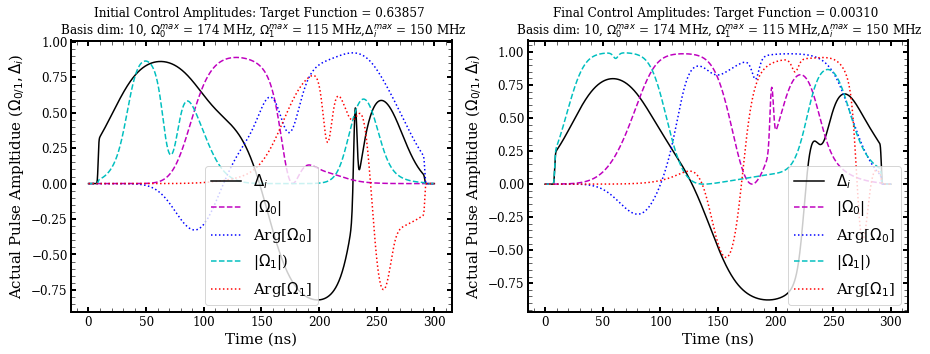

In [161]:
#Set propagator
propagatorVL = PropagatorVL(
    input_dim, nt, pad, f_std, delta_t, del_total, V_int, Delta_i, Rabi_i, Rabi_r,
    Gammas
)

#######Set initial control amplitude guess seeding:
numb_ctrl_amps = 5 # number of control amplitudes (Delta_i, Rabi_iX2, Rabi_rX2)

#Gaussian amplitudes:
propagatorVL.ctrl_amplitudes_a.assign(
    tf.random.uniform([input_dim, numb_ctrl_amps], -1, 1, dtype=tf.float64)
)
# Initialize Gaussian peaks to be Rabi_r before Rabi_i:
# (Keep Delta uniform random)
#Gaussian centers:
propagatorVL.ctrl_amplitudes_b[:, 0].assign(
    tf.random.uniform([input_dim], -1, 1, dtype=tf.float64)
)
  #Set half of the Gaussian centers to order the pulses Rabi_r then Rabi_i:
  #Set magntidues of Rabi:
  #Rabi_i: magnitude
propagatorVL.ctrl_amplitudes_b[:, 1:2].assign(
    tf.random.uniform([input_dim, 1], -0.5, 0.5, dtype=tf.float64)
)
  #Rabi_r: magnitude
propagatorVL.ctrl_amplitudes_b[0:int(input_dim/2), 3:4].assign(
    tf.random.uniform([int(input_dim/2), 1], -1, -0.5, dtype=tf.float64)
)
  #Set half of the Gaussian centers to order the pulses Rabi_i then Rabi_r
  #Rabi_r: magnitude
propagatorVL.ctrl_amplitudes_b[int(input_dim/2):input_dim, 3:4].assign(
    tf.random.uniform([int(input_dim/2), 1], 0.5, 1, dtype=tf.float64)
)

  #Set phases of Rabi: (uniformaly)
    #Rabi_i: phase
propagatorVL.ctrl_amplitudes_b[:, 2:3].assign(
    tf.random.uniform([input_dim, 1], -1, 1, dtype=tf.float64)
)
    #Rabi_r: phase
propagatorVL.ctrl_amplitudes_b[:, 4:5].assign(
    tf.random.uniform([input_dim, 1], -1, 1, dtype=tf.float64)
)

#Gaussian widths:
propagatorVL.ctrl_amplitudes_c.assign(
    tf.random.uniform([input_dim, numb_ctrl_amps], 0, 0.5, dtype=tf.float64)
)

#Find infidelity using propagator
initial_infidelity = propagatorVL.target()

#Plot initial guess pulses:
labels = [
          '$\Delta_i$', '|$\Omega_0$|', 'Arg[$\Omega_0$]',
          '|$\Omega_1$|)', 'Arg[$\Omega_1$]'
]
colors = ['k', 'm--', 'b:', 'c--','r:']
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
ind = 0
physical_amplitudes_initial = propagatorVL.return_physical_amplitudes().numpy()

for amplitdue in tf.transpose(physical_amplitudes_initial):
    #Plotting actual physical input amplitudes: 
    ax1.plot(tlist/ns, amplitdue, colors[ind], label = labels[ind])
    ind += 1
ax1.set_title(
    'Initial Control Amplitudes: Target Function = %2.5f \n \
Basis dim: %.0f, $\Omega_0^{max}$ = %.0f MHz, $\Omega_1^{max}$ = %.0f MHz,\
$\Delta_i^{max}$ = %.0f MHz' 
%(initial_infidelity, input_dim, Rabi_i/(2 * np.pi * MHz), Rabi_r/(2 * np.pi * MHz), \
  Delta_i/(2 * np.pi * MHz)
  ), fontsize = 12
)
ax1.set_ylabel('Actual Pulse Ampltidue ($\Omega_{0/1}, \Delta_i$)')
ax1.set_xlabel('Time (ns)')
ax1.legend()

#Optimize pulse with gradient accent:
optimizer = tf.keras.optimizers.Adam(learn_rate)

@tf.function
def optimization_step():
    with tf.GradientTape() as tape:
        infidelity = propagatorVL.target()
    gradients = tape.gradient(infidelity, [propagatorVL.ctrl_amplitudes_a, propagatorVL.ctrl_amplitudes_b, propagatorVL.ctrl_amplitudes_c])
    optimizer.apply_gradients(zip(gradients, [propagatorVL.ctrl_amplitudes_a, propagatorVL.ctrl_amplitudes_b, propagatorVL.ctrl_amplitudes_c]))
    return propagatorVL.target()

#Measure run time:
start = time.time()

print('step 0: Figure of Merit = %2.5f' %
          (initial_infidelity))

best_infidelity = 1
steps = range(num_iters)
for step in steps:
    current_infidelity = optimization_step()
    if (step + 1) % 50 == 0:
        print('step%2d: Figure of Merit = %2.5f' %
              (step + 1, current_infidelity))
    #keep best result:
    if current_infidelity < best_infidelity:
        best_infidelity = current_infidelity

physical_amplitudes_final = propagatorVL.return_physical_amplitudes().numpy()

#Measure run time:
end = time.time()
print('Run Time: %2.4f seconds' %(end-start))

#Plot final results of control amplitudes
ind = 0
for amplitdue in physical_amplitudes_final.T:
    #Plotting final physical amplitudes: 
    ax2.plot(tlist/ns, amplitdue, colors[ind], label = labels[ind])
    ind += 1
ax2.set_title(
    'Final Control Amplitudes: Target Function = %2.5f \n \
Basis dim: %.0f, $\Omega_0^{max}$ = %.0f MHz, $\Omega_1^{max}$ = %.0f MHz,\
$\Delta_i^{max}$ = %.0f MHz' 
%(current_infidelity, input_dim, Rabi_i/(2 * np.pi * MHz), Rabi_r/(2 * np.pi * MHz), \
  Delta_i/(2 * np.pi * MHz)
  ), fontsize = 12
)
ax2.set_ylabel('Actual Pulse Ampltidue ($\Omega_{0/1}, \Delta_i$)')
ax2.set_xlabel('Time (ns)')
ax2.legend()

print('Best figure of merit: %2.5f' %best_infidelity)

# Qutip ME Hamiltonian

In [ ]:
##Use final optimized pulse in Master Equation to get actual final fidelity:
def nLevelAtomBasis(n):
    states = []
    for n_l in range(0,n):
        states.append(qutip.basis(n, n_l))
    return np.array(states, dtype=object)
def QTHamiltonian(argsME5lvl):
    psi0, psi_orth, Rabi_i_max, Rabi_r_max, Rabi_i_Pulse_Re, Rabi_r_Pulse_Re, Rabi_i_Pulse_Im, \
    Rabi_r_Pulse_Im, Delta_i_Pulse, Delta_i_max, del_total, \
    Gamma_i1, Gamma_i0, Gamma_10 = argsME5lvl

    ##set dimension of Hilbert space:
    dim = 5
    
    #Set operators:
    g_0, g_1, i, r, dark = nLevelAtomBasis(dim) # basis are ground
    
    sig_00 = g_0 * g_0.dag()
    sig_11 = g_1 * g_1.dag()
    sig_ii = i * i.dag()
    sig_rr = r * r.dag()
    sig_01 = g_0 * g_1.dag()
    sig_1i = g_1 * i.dag()
    sig_dr = dark * r.dag()
    sig_ir = i * r.dag()

    ##Set single qubit hamiltonian parts:
    H_SQ_del = - del_total * sig_rr
    H_SQ_Delta_i = - Delta_i_max * sig_ii 
    H_SQ_Rabi_i_re =  - 1/2 * Rabi_i_max * (sig_1i + sig_1i.dag())
    H_SQ_Rabi_i_im = - 1j/2 * Rabi_i_max * (sig_1i - sig_1i.dag())
    H_SQ_Rabi_r_re =  - 1/2 * Rabi_r_max * (sig_ir + sig_ir.dag())
    H_SQ_Rabi_r_im = - 1j/2 * Rabi_r_max * (sig_ir - sig_ir.dag())

    #Set two qubit static terms
    H_TQ_del_total = tensor(identity(dim), H_SQ_del) + tensor(H_SQ_del, identity(dim))
    H_TQ_0 = H_TQ_del_total + V_int * tensor(sig_rr, sig_rr) 
    
    #Set single photon detunings:
    H_TQ_Delta = tensor(identity(dim), H_SQ_Delta_i) + tensor(H_SQ_Delta_i, identity(dim))

    #Real part
    #Set drive 1:(use same power on each qubit))
    H_TQ_Rabi_i_re = tensor(H_SQ_Rabi_i_re, identity(dim)) + \
                  tensor(identity(dim), H_SQ_Rabi_i_re)
    #Set second qubit drive 1: 
    H_TQ_Rabi_r_re = tensor(H_SQ_Rabi_r_re, identity(dim)) + \
                  tensor(identity(dim), H_SQ_Rabi_r_re)
    
    #Imaginary part
    H_TQ_Rabi_i_im = tensor(H_SQ_Rabi_i_im, identity(dim)) + \
                  tensor(identity(dim), H_SQ_Rabi_i_im)
    #Set second qubit drive 1: 
    H_TQ_Rabi_r_im = tensor(H_SQ_Rabi_r_im, identity(dim)) + \
                  tensor(identity(dim), H_SQ_Rabi_r_im)

    H = [H_TQ_0, [H_TQ_Delta, Delta_i_Pulse], [H_TQ_Rabi_i_re, Rabi_i_Pulse_Re],
         [H_TQ_Rabi_i_im, Rabi_i_Pulse_Im], [H_TQ_Rabi_r_re, Rabi_r_Pulse_Re],
         [H_TQ_Rabi_r_im, Rabi_r_Pulse_Im]
         ]
    return H

def Mesolve_5lvl_t(time, argsME5lvl):
    psi0, psi_orth, Rabi_i_max, Rabi_r_max, Rabi_i_Pulse_Re, Rabi_r_Pulse_Re, Rabi_i_Pulse_Im, \
    Rabi_r_Pulse_Im, Delta_i_Pulse, Delta_i_max, del_total, \
    Gamma_i1, Gamma_i0, Gamma_10 = argsME5lvl

    H = QTHamiltonian(argsME5lvl)

    ##set dimension of Hilbert space:
    dim = 5
    
    #Set operators:
    g_0, g_1, i, r, dark = nLevelAtomBasis(dim) # basis are ground
    
    sig_00 = g_0 * g_0.dag()
    sig_11 = g_1 * g_1.dag()
    sig_ii = i * i.dag()
    sig_rr = r * r.dag()
    sig_01 = g_0 * g_1.dag()
    sig_1i = g_1 * i.dag()
    sig_dr = dark * r.dag()
    sig_ir = i * r.dag()

    #Set decay:
    Decay_ops = []
    ops = [sig_01, sig_1i, sig_ir, sig_dr]
    Gammas_list = [Gamma_10, Gamma_i1, Gamma_ri, Gamma_rd]

    #Loop over each Gamma:
    for Gamma_ind in range(len(ops)):
        #loop for qubit 1 and 2:
        for qubit_ind in range(2):
            op = [identity(dim), identity(dim)]
            op[qubit_ind] = ops[Gamma_ind]
            Decay = np.sqrt(Gammas_list[Gamma_ind]) * tensor(op)
            Decay_ops.append(Decay)

    options1 = Options()
    options1.max_step = 1e-9

    #Finds expectation of p_rr and p_ii and p_gg:
    result = mesolve(H, psi0, time, Decay_ops, [
                    psi0 * psi0.dag(), psi_orth * psi_orth.dag(),
                    tensor(sig_ii, identity(dim)) * tensor(sig_ii, identity(dim)).dag(),
                    tensor(sig_rr, sig_rr) * tensor(sig_rr, sig_rr).dag()
    ], options = options1, args = {}
    ) 
    return result


# Run Qutip Simulation

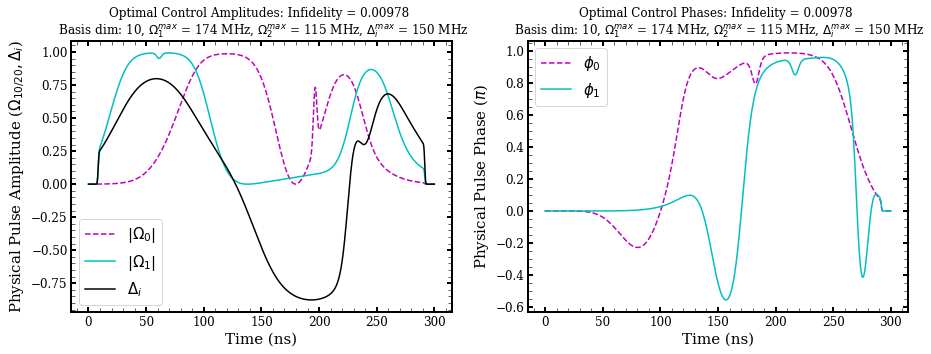

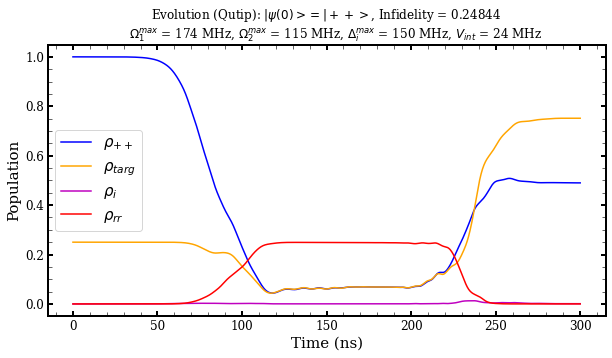

In [162]:
#Test robustness:
#Set percentage of original amplitude:
Percent_amp = 1

#Set actual pulse amplitudes (tanh(ctrl_amplitudes))
Rabi_i_Pulse_real_opt = Percent_amp * physical_amplitudes_final[:,1] * \
                  np.cos(np.pi * physical_amplitudes_final[:,2])
Rabi_i_Pulse_opt_real_S = Cubic_Spline(tlist[0], tlist[-1], Rabi_i_Pulse_real_opt) #interpolated data for time evolution
Rabi_i_Pulse_imag_opt = Percent_amp * physical_amplitudes_final[:,1] * \
                  np.sin(np.pi * physical_amplitudes_final[:,2])
Rabi_i_Pulse_opt_imag_S = Cubic_Spline(tlist[0], tlist[-1], Rabi_i_Pulse_imag_opt) #interpolated data for time evolution

Rabi_r_Pulse_real_opt = Percent_amp * physical_amplitudes_final[:,3] * \
                  np.cos(np.pi * physical_amplitudes_final[:,4])
Rabi_r_Pulse_opt_real_S = Cubic_Spline(tlist[0], tlist[-1], Rabi_r_Pulse_real_opt)
Rabi_r_Pulse_imag_opt = Percent_amp * physical_amplitudes_final[:,3] * \
                  np.sin(np.pi * physical_amplitudes_final[:,4])
Rabi_r_Pulse_opt_imag_S = Cubic_Spline(tlist[0], tlist[-1], Rabi_r_Pulse_imag_opt)

Delta_i_opt = Percent_amp * physical_amplitudes_final[:,0]
Delta_i_opt_S = Cubic_Spline(tlist[0], tlist[-1], Delta_i_opt)

#Convert real and imaginary parts of Rabi frequency into amplitude and phase
Rabi_i_amplitude = np.sqrt(Rabi_i_Pulse_opt_real_S(tlist)**2 + Rabi_i_Pulse_opt_imag_S(tlist)**2)
Rabi_i_phase = np.pi * physical_amplitudes_final[:,2]
Rabi_r_amplitude = np.sqrt(Rabi_r_Pulse_opt_real_S(tlist)**2 + Rabi_r_Pulse_opt_imag_S(tlist)**2)
Rabi_r_phase = np.pi * physical_amplitudes_final[:,4]

#Plot pulse shape:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
ax1.plot(tlist/ns, Rabi_i_amplitude, 'm--', label = r'|$\Omega_0$|')
ax1.plot(tlist/ns, Rabi_r_amplitude, 'c-', label = r'|$\Omega_1$|')
ax1.plot(tlist/ns, Delta_i_opt_S(tlist), 'k', label = r'$\Delta_i$')

ax2.plot(tlist/ns, Rabi_i_phase/np.pi, 'm--', label = r'$\phi_0$')
ax2.plot(tlist/ns, Rabi_r_phase/np.pi, 'c-', label = r'$\phi_1$')

ax1.set_xlabel(r'Time (ns)');
ax2.set_xlabel(r'Time (ns)');

ax1.set_ylabel(r'Physical Pulse Amplitude ($\Omega_{10/20}, \Delta_i$)');
ax2.set_ylabel(r'Physical Pulse Phase ($\pi$)');

ax1.set_title(
    'Optimal Control Amplitudes: Infidelity = %2.5f \n \
Basis dim: %.0f, $\Omega_1^{max}$ = %.0f MHz, $\Omega_2^{max}$ = %.0f MHz, \
$\Delta_i^{max}$ = %.0f MHz' 
%(propagatorVL.metrics()[0], input_dim, Rabi_i/(2 * np.pi * MHz), Rabi_r/(2 * np.pi * MHz), \
  Delta_i/(2 * np.pi * MHz)
  ), fontsize = 12
)
ax2.set_title(
    'Optimal Control Phases: Infidelity = %2.5f \n \
Basis dim: %.0f, $\Omega_1^{max}$ = %.0f MHz, $\Omega_2^{max}$ = %.0f MHz, \
$\Delta_i^{max}$ = %.0f MHz' 
%(propagatorVL.metrics()[0], input_dim, Rabi_i/(2 * np.pi * MHz), Rabi_r/(2 * np.pi * MHz), \
  Delta_i/(2 * np.pi * MHz)
  ), fontsize = 12
)
ax1.legend();
ax2.legend();

###Solve ME:
g_0, g_1, i, r, dark = nLevelAtomBasis(5) # basis are ground
#Set initial states and target state:
psi0 = 1/2 * (tensor(g_0, g_0) + tensor(g_0, g_1) + \
              tensor(g_1, g_0) + tensor(g_1, g_1))
psi_targ = 1/2 * (tensor(g_0, g_0) + tensor(g_0, g_1) + \
              tensor(g_1, g_0) - tensor(g_1, g_1))

#Set parameters for Hamiltonian
argsME5lvl = [psi0, psi_targ, Rabi_i, Rabi_r,
              Rabi_i_Pulse_opt_real_S, Rabi_r_Pulse_opt_real_S,
              Rabi_i_Pulse_opt_imag_S, Rabi_r_Pulse_opt_imag_S,
              Delta_i_opt_S, Delta_i, del_total, Gamma_i1, Gamma_i0, Gamma_10
        ]

# #Solve Propagator Equation: Superoperator
result = Mesolve_5lvl_t(tlist, argsME5lvl)

rho_0_t = result.expect[0]
rho_orth_t = result.expect[1]
rho_i_t = result.expect[2]
rho_rr_t = result.expect[3]

# #Plot population evolution:
fig, ax1 = plt.subplots(1, 1,figsize=(10,5))

ax1.plot(tlist/ns, rho_0_t, 'b', label = r'$\rho_{++}$')
ax1.plot(tlist/ns, rho_orth_t, 'orange', label = r'$\rho_{targ}$')
ax1.plot(tlist/ns, rho_i_t, 'm', label = r'$\rho_{i}$')
ax1.plot(tlist/ns, rho_rr_t, 'red', label = r'$\rho_{rr}$')

ax1.set_xlabel(r'Time (ns)');
ax1.set_ylabel(r'Population');
ax1.set_title(
    'Evolution (Qutip): $|\psi(0) > = |++>$, Infidelity = %2.5f \n \
    $\Omega_1^{max}$ = %.0f MHz, $\Omega_2^{max}$ = %.0f MHz, \
$\Delta_i^{max}$ = %.0f MHz, $V_{int}$ = %.0f MHz' 
%(1 - rho_orth_t[-1], Rabi_i/(2 * np.pi * MHz), Rabi_r/(2 * np.pi * MHz), \
  Delta_i/(2 * np.pi * MHz), V_int/(2*np.pi*MHz)
  ), fontsize = 12
)
ax1.legend();


# Single Atom Dark State Overlap: |$\psi(0)\rangle =  |10\rangle$ and $|11\rangle$ 

Text(0.5, 1.0, 'Dark State Overlap \n     $\\Omega_0^{max}$ = 174 MHz, $\\Omega_1^{max}$ = 115 MHz,    $\\Delta_i^{max}$ = 150 MHz, $V_{int}$ = 24 MHz')

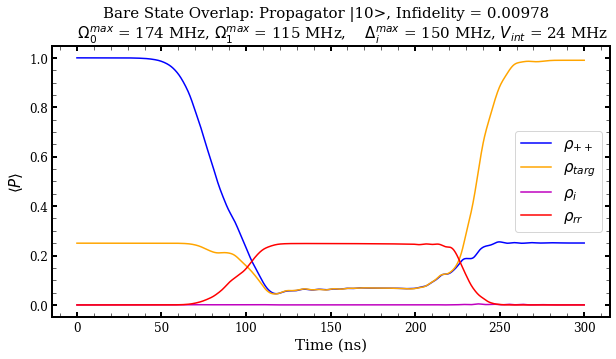

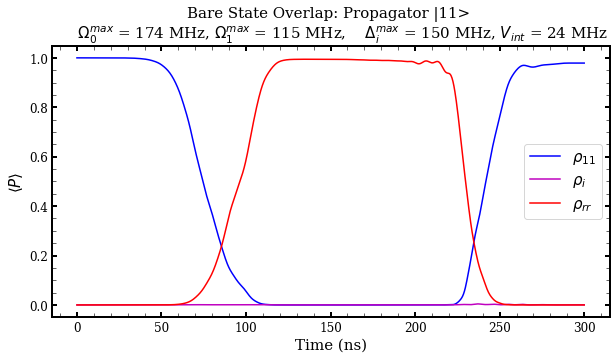

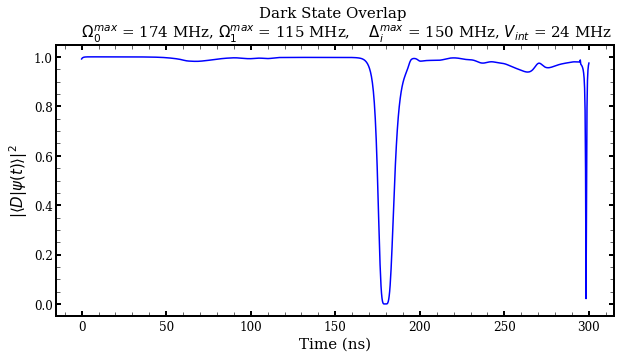

In [163]:
##Find overlap of the dark state with the actual state over the evolution:
DS_overlap_squared = []
i_overlap_squared = []
rr_overlap_squared = []
plus_overlap_squared = []
targ_overlap_squared = []

state11_11_overlap_squared = []
state11_rr_overlap_squared = []
state11_i_overlap_squared = []

dim = propagatorVL.dim
exps = propagatorVL.exponentials()
g_0, g_1, i, r = propagatorVL.nLevelAtomBasis(propagatorVL.dim)

#initialize current state:
current_state_pp = propagatorVL.psi_pp
current_state_10 = propagatorVL.psi_10
current_state_11 = propagatorVL.psi_11


for ind in range(propagatorVL.no_of_steps + 2 * propagatorVL.padding):

    # #Find the instantaneous dark state: initial state|10>
    # # (depends on the instantaneous Rabi frequencies)
    current_Rabi_i_real = Rabi_i * physical_amplitudes_final[ind,1] * \
                  np.cos(np.pi * physical_amplitudes_final[ind,2])
    current_Rabi_i_imag = Rabi_i * physical_amplitudes_final[ind,1] * \
                  np.sin(np.pi * physical_amplitudes_final[ind,2])
    current_Rabi_r_real = Rabi_r * physical_amplitudes_final[ind,3] * \
                  np.cos(np.pi * physical_amplitudes_final[ind,4])
    current_Rabi_r_imag = Rabi_r * physical_amplitudes_final[ind,3] * \
                  np.sin(np.pi * physical_amplitudes_final[ind,4])

    #Find dark state: D = Rabi_r |1> - Rabi_i* |r>
    norm_dark = 1 / np.sqrt(
        current_Rabi_i_real**2 + current_Rabi_i_imag**2 \
        + current_Rabi_r_real**2 + current_Rabi_r_imag**2
    )
    dark_state = norm_dark * (
        (current_Rabi_r_real + 1j * current_Rabi_r_imag) * tensor(g_1, g_0) \
        - (current_Rabi_i_real - 1j * current_Rabi_i_imag) * tensor(r, g_0)
    )
    #Find overlap squared between current state and the dark state
    darkstate_overlap = tf.linalg.matmul(
        current_state_10, dark_state, adjoint_a = True
    )[0,0]
    DS_overlap_squared.append(
        tf.math.real(tf.math.conj(darkstate_overlap) * darkstate_overlap)
    )
    #Find the state at time step i:
    current_state_10 = tf.linalg.matmul(
        exps[ind, 0:propagatorVL.dim**2, 0:propagatorVL.dim**2], current_state_10
    )

    ##For initial state |++>:
    #Find ++, target, and rr populations:
    plus = 1/np.sqrt(2) * (g_0 + g_1)
    plus_overlap = tf.linalg.matmul(
        current_state_pp, tf.cast(tensor(plus, plus), dtype = tf.complex128), adjoint_a = True
    )[0,0]
    plus_overlap_squared.append(
        tf.math.real(tf.math.conj(plus_overlap) * plus_overlap)
    )

    targ_two_qubit = 1/2 * (tensor(g_0, g_0) + tensor(g_1, g_0) + \
                             tensor(g_0, g_1) - tensor(g_1, g_1))
    targ_overlap = tf.linalg.matmul(
        current_state_pp, tf.cast(targ_two_qubit, dtype = tf.complex128), adjoint_a = True
    )[0,0]
    targ_overlap_squared.append(
        tf.math.real(tf.math.conj(targ_overlap) * targ_overlap)
    )

    rr_overlap = tf.linalg.matmul(
        current_state_pp, tf.cast(tensor(r, r), dtype = tf.complex128), adjoint_a = True
    )[0,0]
    rr_overlap_squared.append(
        tf.math.real(tf.math.conj(rr_overlap) * rr_overlap)
    )
    i_overlap = tf.linalg.matmul(
        current_state_pp, tf.cast(tensor(i, identity(dim)), dtype = tf.complex128), adjoint_a = True
    )[0,0]
    i_overlap_squared.append(
        tf.math.real(tf.math.conj(i_overlap) * i_overlap)
    )

    #Find the state at time step i:
    current_state_pp = tf.linalg.matmul(
        exps[ind, 0:propagatorVL.dim**2, 0:propagatorVL.dim**2], current_state_pp
    )


    ##For initial state |11>:
    #Find 11, and rr populations:
    state11_11_overlap = tf.linalg.matmul(
        current_state_11, tf.cast(tensor(g_1, g_1), dtype = tf.complex128), adjoint_a = True
    )[0,0]
    state11_11_overlap_squared.append(
        tf.math.real(tf.math.conj(state11_11_overlap) * state11_11_overlap)
    )


    state11_rr_overlap = tf.linalg.matmul(
        current_state_11, tf.cast(tensor(r, r), dtype = tf.complex128), adjoint_a = True
    )[0,0]
    state11_rr_overlap_squared.append(
        tf.math.real(tf.math.conj(state11_rr_overlap) * state11_rr_overlap)
    )
    state11_i_overlap = tf.linalg.matmul(
        current_state_pp, tf.cast(tensor(i, identity(dim)), dtype = tf.complex128), adjoint_a = True
    )[0,0]
    state11_i_overlap_squared.append(
        tf.math.real(tf.math.conj(state11_i_overlap) * state11_i_overlap)
    )

    #Find the state at time step i:
    current_state_11 = tf.linalg.matmul(
        exps[ind, 0:propagatorVL.dim**2, 0:propagatorVL.dim**2], current_state_11
    )

# Plot g, i, r populations using TF class propagator
fig, (ax) = plt.subplots(1, 1,figsize=(10,5))

ax.plot(tlist/ns, plus_overlap_squared, 'b', label = r'$\rho_{++}$')
ax.plot(tlist/ns, targ_overlap_squared, 'orange', label = r'$\rho_{targ}$')
ax.plot(tlist/ns, i_overlap_squared, 'm', label = r'$\rho_{i}$')
ax.plot(tlist/ns, rr_overlap_squared, 'red', label = r'$\rho_{rr}$')

ax.set_xlabel(r'Time (ns)');
ax.set_ylabel(r'$\langle P \rangle$');
ax.set_title(
    'Bare State Overlap: Propagator |10>, Infidelity = %2.5f  \n \
    $\Omega_0^{max}$ = %.0f MHz, $\Omega_1^{max}$ = %.0f MHz,\
    $\Delta_i^{max}$ = %.0f MHz, $V_{int}$ = %.0f MHz' 
    %(1 - targ_overlap_squared[-1], Rabi_i/(2 * np.pi * MHz), Rabi_r/(2 * np.pi * MHz), \
      Delta_i/(2 * np.pi * MHz), V_int/(2*np.pi*MHz)
      ), fontsize = 15
    )
ax.legend()

# Plot g, i, r populations using TF class propagator
fig, (ax) = plt.subplots(1, 1,figsize=(10,5))

ax.plot(tlist/ns, state11_11_overlap_squared, 'b', label = r'$\rho_{11}$')
ax.plot(tlist/ns, state11_i_overlap_squared, 'm', label = r'$\rho_{i}$')
ax.plot(tlist/ns, state11_rr_overlap_squared, 'red', label = r'$\rho_{rr}$')

ax.set_xlabel(r'Time (ns)');
ax.set_ylabel(r'$\langle P \rangle$');
ax.set_title(
    'Bare State Overlap: Propagator |11> \n \
    $\Omega_0^{max}$ = %.0f MHz, $\Omega_1^{max}$ = %.0f MHz,\
    $\Delta_i^{max}$ = %.0f MHz, $V_{int}$ = %.0f MHz' 
    %(Rabi_i/(2 * np.pi * MHz), Rabi_r/(2 * np.pi * MHz), \
      Delta_i/(2 * np.pi * MHz), V_int/(2*np.pi*MHz)
      ), fontsize = 15
    )
ax.legend()

# Plot dark state overlap throughout the pulse duration:
fig, (ax) = plt.subplots(1, 1,figsize=(10,5))
ax.plot(tlist/ns, DS_overlap_squared, 'b')
ax.set_xlabel(r'Time (ns)');
ax.set_ylabel(r'$|\langle D|\psi(t)\rangle|^2$');
ax.set_title(
    'Dark State Overlap \n \
    $\Omega_0^{max}$ = %.0f MHz, $\Omega_1^{max}$ = %.0f MHz,\
    $\Delta_i^{max}$ = %.0f MHz, $V_{int}$ = %.0f MHz' 
    %(Rabi_i/(2 * np.pi * MHz), Rabi_r/(2 * np.pi * MHz), \
      Delta_i/(2 * np.pi * MHz), V_int/(2*np.pi*MHz)
      ), fontsize = 15
    )

# Two atom eigenstate: |$\psi(0)\rangle =  |11\rangle$

In [9]:
#Function that finds eigenvectors and eigenvalues at given time:
def Eigen(time, argsEigen):
    Rabi_i_max, Rabi_r_max, Rabi_i_Pulse_Re, Rabi_r_Pulse_Re, Rabi_i_Pulse_Im, \
    Rabi_r_Pulse_Im, Delta_i_Pulse, Delta_i_max, del_total = argsEigen

    ##set dimension of Hilbert space:
    dim = 4
    
    #Set operators:
    g_0, g_1, i, r = nLevelAtomBasis(dim) # basis are ground
    
    sig_00 = g_0 * g_0.dag()
    sig_11 = g_1 * g_1.dag()
    sig_ii = i * i.dag()
    sig_rr = r * r.dag()
    sig_01 = g_0 * g_1.dag()
    sig_1i = g_1 * i.dag()
    sig_ir = i * r.dag()

    ##Set single qubit hamiltonian parts:
    H_SQ_del = - del_total * sig_rr
    H_SQ_Delta_i = - Delta_i_max * sig_ii 
    H_SQ_Rabi_i_re =  - 1/2 * Rabi_i_max * (sig_1i + sig_1i.dag())
    H_SQ_Rabi_i_im = - 1j/2 * Rabi_i_max * (sig_1i - sig_1i.dag())
    H_SQ_Rabi_r_re =  - 1/2 * Rabi_r_max * (sig_ir + sig_ir.dag())
    H_SQ_Rabi_r_im = - 1j/2 * Rabi_r_max * (sig_ir - sig_ir.dag())

    #Set two qubit static terms
    H_TQ_del_total = tensor(identity(dim), H_SQ_del) + tensor(H_SQ_del, identity(dim))
    H_TQ_0 = H_TQ_del_total + V_int * tensor(sig_rr, sig_rr) 
    
    #Set single photon detunings:
    H_TQ_Delta = tensor(identity(dim), H_SQ_Delta_i) + tensor(H_SQ_Delta_i, identity(dim))

    #Real part
    #Set drive 1:(use same power on each qubit))
    H_TQ_Rabi_i_re = tensor(H_SQ_Rabi_i_re, identity(dim)) + \
                  tensor(identity(dim), H_SQ_Rabi_i_re)
    #Set second qubit drive 1: 
    H_TQ_Rabi_r_re = tensor(H_SQ_Rabi_r_re, identity(dim)) + \
                  tensor(identity(dim), H_SQ_Rabi_r_re)
    
    #Imaginary part
    H_TQ_Rabi_i_im = tensor(H_SQ_Rabi_i_im, identity(dim)) + \
                  tensor(identity(dim), H_SQ_Rabi_i_im)
    #Set second qubit drive 1: 
    H_TQ_Rabi_r_im = tensor(H_SQ_Rabi_r_im, identity(dim)) + \
                  tensor(identity(dim), H_SQ_Rabi_r_im)

    H = H_TQ_0 + H_TQ_Delta * Delta_i_Pulse(time) + H_TQ_Rabi_i_re * Rabi_i_Pulse_Re(time) \
         + H_TQ_Rabi_i_im * Rabi_i_Pulse_Im(time) + H_TQ_Rabi_r_re * Rabi_r_Pulse_Re(time) \
         + H_TQ_Rabi_r_im * Rabi_r_Pulse_Im(time)

    # return tf.linalg.eigh(H)
    return H.eigenstates() #gives eigenenergy, eienvectors

##Find overlap of the eigenvector for 11 state with the actual state over the evolution:
eigen11_overlap_squared = []

dim = propagatorVL.dim
exps = propagatorVL.exponentials()
g_0, g_1, i, r = propagatorVL.nLevelAtomBasis(propagatorVL.dim)

#initialize current state:
current_state_11 = propagatorVL.psi_11

argsEigen = [Rabi_i, Rabi_r,
              Rabi_i_Pulse_opt_real_S, Rabi_r_Pulse_opt_real_S,
              Rabi_i_Pulse_opt_imag_S, Rabi_r_Pulse_opt_imag_S,
              Delta_i_opt_S, Delta_i, del_total
        ]

eigenenergy_plot = np.zeros([dim**2, len(tlist)])
eienvectors_11_plot = np.zeros([dim**2, len(tlist)])
eienvectors_rr_plot = np.zeros([dim**2, len(tlist)])

# for ind_time in range(len(tlist)):
for ind_time in range(len(tlist)):

    #find eigenvalues and vectors
    eigenenergy, eienvectors = Eigen(tlist[ind_time], argsEigen)
    eigenenergy_plot[:, ind_time] = eigenenergy

    for ind_eig in range(dim**2):
        # eienvectors_11_plot[ind_eig, ind_time] = tf.tensordot(
        #     eienvectors[:,ind_eig],
        #     tensor(g_1, g_1),
        #     axes = 1
        # )[0]

        # eienvectors_rr_plot[ind_eig, ind_time] = tf.tensordot(
        #     eienvectors[:,ind_eig],
        #     tensor(r, r),
        #     axes = 1
        # )[0]

        eienvectors_11_plot[ind_eig, ind_time] = expect(
            tensor(g_1 * g_1.dag(), g_1 * g_1.dag()),
            ket2dm(eienvectors[ind_eig])
        )
        eienvectors_rr_plot[ind_eig, ind_time] = expect(
            tensor(r * r.dag(), r * r.dag()),
            ket2dm(eienvectors[ind_eig])
        )

        eienvectors_11_plot[ind_eig, ind_time] = tf.math.abs(
              eienvectors_11_plot[ind_eig, ind_time]
        )**2

        eienvectors_rr_plot[ind_eig, ind_time] = tf.math.abs(
              eienvectors_rr_plot[ind_eig, ind_time]
        )**2

Text(0.5, 1.0, 'Eigenstate: $|\\psi(0)\\rangle = |11\\rangle$ \\\n    $\\Omega_0^{max}$ = 174 MHz, $\\Omega_1^{max}$ = 115 MHz, $\\Delta_i^{max}$ = 150 MHz, $V_{int}$ = 24 MHz')

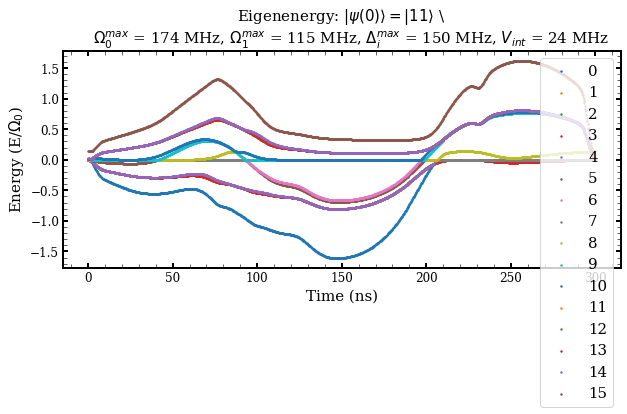

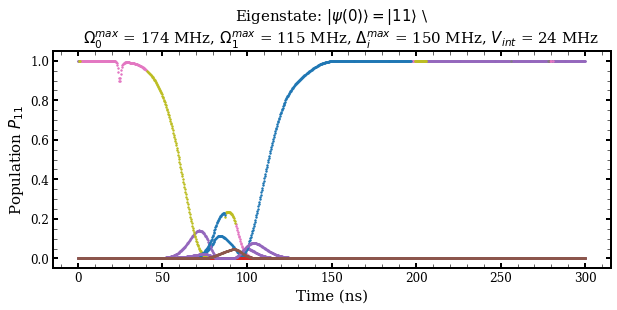

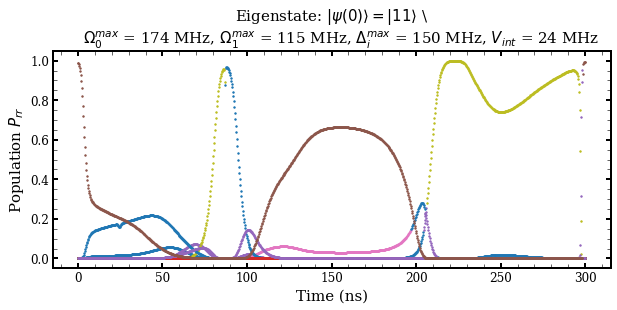

In [10]:
#Eigenvalues:
fig, (ax) = plt.subplots(1, 1,figsize=(10,4))

# ind=12
# ax.scatter(tlist/ns, eigenenergy_plot[ind]/Rabi_i, s=2, label = r'$\rho_{++}$')

for ind in range(dim**2): 
    ax.scatter(tlist/ns, eigenenergy_plot[ind]/Rabi_i, s=2, label = '%.0f' %ind)

ax.set_xlabel(r'Time (ns)');
ax.set_ylabel(r'Energy (E/$\Omega_0$)');
ax.set_title(
    r'Eigenenergy: $|\psi(0)\rangle = |11\rangle$ \
    $\Omega_0^{max}$ = %.0f MHz, $\Omega_1^{max}$ = %.0f MHz, $\Delta_i^{max}$ = %.0f MHz, $V_{int}$ = %.0f MHz' 
    %(Rabi_i/(2 * np.pi * MHz), Rabi_r/(2 * np.pi * MHz), \
      Delta_i/(2 * np.pi * MHz), V_int/(2*np.pi*MHz)
      ), fontsize = 15
    )
ax.legend()

#Eigenstates: <P_11>
fig, (ax) = plt.subplots(1, 1,figsize=(10,4))

for ind in range(dim**2): 
    ax.scatter(tlist/ns, eienvectors_11_plot[ind], s=2, label = r'$\rho_{++}$')

ax.set_xlabel(r'Time (ns)');
ax.set_ylabel(r'Population $P_{11}$');
ax.set_title(
    r'Eigenstate: $|\psi(0)\rangle = |11\rangle$ \
    $\Omega_0^{max}$ = %.0f MHz, $\Omega_1^{max}$ = %.0f MHz, $\Delta_i^{max}$ = %.0f MHz, $V_{int}$ = %.0f MHz' 
    %(Rabi_i/(2 * np.pi * MHz), Rabi_r/(2 * np.pi * MHz), \
      Delta_i/(2 * np.pi * MHz), V_int/(2*np.pi*MHz)
      ), fontsize = 15
    )
# ax.legend()

#Eigenstates: <P_rr>
fig, (ax) = plt.subplots(1, 1,figsize=(10,4))

for ind in range(dim**2): 
    ax.scatter(tlist/ns, eienvectors_rr_plot[ind], s=2, label = r'$\rho_{++}$')

ax.set_xlabel(r'Time (ns)');
ax.set_ylabel(r'Population $P_{rr}$');
ax.set_title(
    r'Eigenstate: $|\psi(0)\rangle = |11\rangle$ \
    $\Omega_0^{max}$ = %.0f MHz, $\Omega_1^{max}$ = %.0f MHz, $\Delta_i^{max}$ = %.0f MHz, $V_{int}$ = %.0f MHz' 
    %(Rabi_i/(2 * np.pi * MHz), Rabi_r/(2 * np.pi * MHz), \
      Delta_i/(2 * np.pi * MHz), V_int/(2*np.pi*MHz)
      ), fontsize = 15
    )
# ax.legend()

# Gate Time vs. Fidelity

In [ ]:
def Optimize_pulse(t_f, num_iters):
    ##Set time grid:
    t_0 = 0 #Initial time
    delta_t = (t_f - t_0)/nt #time difference between steps
    tlist = np.linspace(0, t_f, nt)
    
    #Set propagator
    propagatorVL = PropagatorVL(
        input_dim, nt, delta_t, del_total, V_int, Delta_i, Rabi_i, Rabi_r,
        Gammas
    )

    #######Set initial control amplitude guess seeding:
    numb_ctrl_amps = 5 # number of control amplitudes (Delta_0, Rabi_0X2, Rabi_1X2)

    #Gaussian amplitudes:
    propagatorVL.ctrl_amplitudes_a.assign(
        tf.random.uniform([input_dim, numb_ctrl_amps], -1, 1, dtype=tf.float64)
    )
    # Initialize Gaussian peaks to be Rabi_r before Rabi_i:
    # (Keep Delta uniform random)
    #Gaussian centers:
    propagatorVL.ctrl_amplitudes_b[:, 0].assign(
        tf.random.uniform([input_dim], -1, 1, dtype=tf.float64)
    )
      #Set half of the Gaussian centers to order the pulses Rabi_r then Rabi_i:
      #Set magntidues of Rabi:
      #Rabi_i: magnitude
    propagatorVL.ctrl_amplitudes_b[:, 1:2].assign(
        tf.random.uniform([input_dim, 1], -0.5, 0.5, dtype=tf.float64)
    )
      #Rabi_r: magnitude
    propagatorVL.ctrl_amplitudes_b[0:int(input_dim/2), 3:4].assign(
        tf.random.uniform([int(input_dim/2), 1], -1, -0.5, dtype=tf.float64)
    )
      #Set half of the Gaussian centers to order the pulses Rabi_i then Rabi_r
      #Rabi_r: magnitude
    propagatorVL.ctrl_amplitudes_b[int(input_dim/2):input_dim, 3:4].assign(
        tf.random.uniform([int(input_dim/2), 1], 0.5, 1, dtype=tf.float64)
    )

      #Set phases of Rabi: (uniformaly)
        #Rabi_i: phase
    propagatorVL.ctrl_amplitudes_b[:, 2:3].assign(
        tf.random.uniform([input_dim, 1], -1, 1, dtype=tf.float64)
    )
        #Rabi_r: phase
    propagatorVL.ctrl_amplitudes_b[:, 4:5].assign(
        tf.random.uniform([input_dim, 1], -1, 1, dtype=tf.float64)
    )

    #Gaussian widths:
    propagatorVL.ctrl_amplitudes_c.assign(
        tf.random.uniform([input_dim, numb_ctrl_amps], 0, 0.5, dtype=tf.float64)
    )

    #Find infidelity using propagator
    initial_infidelity = propagatorVL.target()

    #Optimize pulse with gradient accent:
    optimizer = tf.keras.optimizers.Adam(learn_rate)

    @tf.function
    def optimization_step():
        with tf.GradientTape() as tape:
            infidelity = propagatorVL.target()
        gradients = tape.gradient(infidelity, [propagatorVL.ctrl_amplitudes_a, propagatorVL.ctrl_amplitudes_b, propagatorVL.ctrl_amplitudes_c])
        optimizer.apply_gradients(zip(gradients, [propagatorVL.ctrl_amplitudes_a, propagatorVL.ctrl_amplitudes_b, propagatorVL.ctrl_amplitudes_c]))
        return propagatorVL.target()


    # print('Final step: Figure of Merit = %2.5f' %
    #           (initial_infidelity))
    steps = range(num_iters)
    for step in steps:
        current_infidelity = optimization_step()
        # if (step + 1) % 50 == 0:
        #     print('step%2d: Figure of Merit = %2.5f' %
        #           (step + 1, current_infidelity))
    physical_amplitudes_final = propagatorVL.return_physical_amplitudes().numpy()

    # print('step 0: Figure of Merit = %2.5f' %
    #           (current_infidelity))

    return physical_amplitudes_final, current_infidelity

Instructions for updating:
Use fn_output_signature instead


Instructions for updating:
Use fn_output_signature instead


Run Time: 3.5376 minutes (1 out of 20 opts)
Run Time: 6.9439 minutes (2 out of 20 opts)
Run Time: 10.3369 minutes (3 out of 20 opts)
Run Time: 13.7206 minutes (4 out of 20 opts)


Run Time: 17.1160 minutes (5 out of 20 opts)


Run Time: 20.5318 minutes (6 out of 20 opts)


Run Time: 23.9387 minutes (7 out of 20 opts)


Run Time: 27.3629 minutes (8 out of 20 opts)


Run Time: 30.7886 minutes (9 out of 20 opts)


Run Time: 34.1915 minutes (10 out of 20 opts)


Run Time: 37.6049 minutes (11 out of 20 opts)


Run Time: 41.0072 minutes (12 out of 20 opts)


Run Time: 44.4437 minutes (13 out of 20 opts)


Run Time: 47.8693 minutes (14 out of 20 opts)


Run Time: 51.2978 minutes (15 out of 20 opts)


Run Time: 54.7553 minutes (16 out of 20 opts)


Run Time: 58.1978 minutes (17 out of 20 opts)


Run Time: 61.6326 minutes (18 out of 20 opts)


Run Time: 65.1023 minutes (19 out of 20 opts)


Run Time: 68.5678 minutes (20 out of 20 opts)


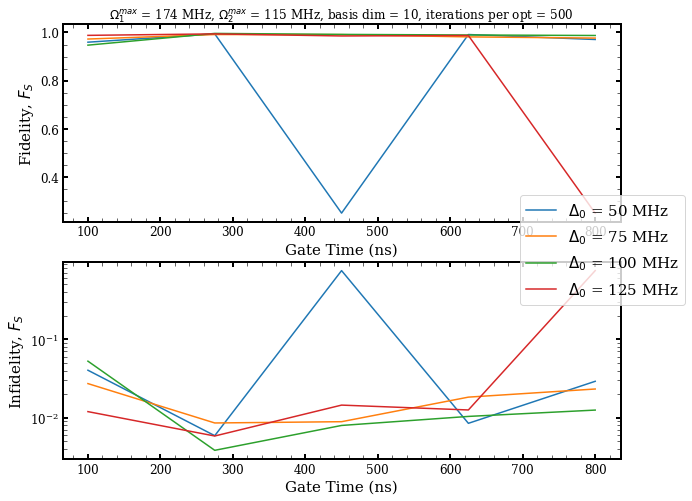

In [ ]:
# Set parameters: 

#Set number of basis functions for the control amplitudes
input_dim = 10 #(number of Gaussian modes)
nt = 1000 #number of time points

#Set number of iterations in the optimization:
num_iters = 500
#Set learn rate for optimizer:
learn_rate = 0.01

##Define basis:
g_0, g_1, i, r, dark = nLevelAtomBasis(5) # basis are ground
psi0 = 1/2 * (tensor(g_0, g_0) + tensor(g_0, g_1) + \
              tensor(g_1, g_0) + tensor(g_1, g_1))
psi_targ = 1/2 * (tensor(g_0, g_0) + tensor(g_0, g_1) + \
              tensor(g_1, g_0) - tensor(g_1, g_1))

######Parameters level :######################

##Set system parameters: (from chapter 7 DeLeseleuc)
Rabi_i = 2*np.pi * 174 * MHz #coupling state 1 to i
Rabi_r = 2*np.pi * 115 * MHz #coupling state i to r

##Set detunings
del_total = 0

#Set interaction strength:
V_int = 2 * np.pi * 24 * MHz #From Omran paper

#Set gate and detuning times:
t_gate_plot = np.linspace(100, 800, 5) * ns
Delta_i_plot = 2*np.pi * np.linspace(50, 125, 4) * MHz 

Fidelity_t_gate = np.zeros([len(Delta_i_plot), len(t_gate_plot)])
TF_infidelity_list = np.zeros([len(Delta_i_plot), len(t_gate_plot)])

ind_tg = 0
ind_delta = 0
#Measure run time:
start = time.time()
count = 1
for Delta_i in Delta_i_plot:
    ind_tg = 0
    for t_gate in t_gate_plot:

        tlist = np.linspace(0, t_gate, nt)

        #Optimize pulse shapes
        physical_amplitudes_final, TF_infidelity_opt = Optimize_pulse(t_gate, num_iters)
        
        #Measure run time:
        end_temp = time.time()
        print('Run Time: %2.4f minutes (%.0f out of %.0f opts)'
            %((end_temp-start)/60, count,
            (len(Delta_i_plot) * len(t_gate_plot)))
        )
    
        ##Solve fidelity with qutip propagator
        #Set percentage of original amplitude:
        Percent_amp = 1

        #Set actual pulse amplitudes (tanh(ctrl_amplitudes))
        Rabi_i_Pulse_real_opt = Percent_amp * physical_amplitudes_final[:,1] * \
                          np.cos(np.pi * physical_amplitudes_final[:,2])
        Rabi_i_Pulse_opt_real_S = Cubic_Spline(tlist[0], tlist[-1], Rabi_i_Pulse_real_opt) #interpolated data for time evolution
        Rabi_i_Pulse_imag_opt = Percent_amp * physical_amplitudes_final[:,1] * \
                          np.sin(np.pi * physical_amplitudes_final[:,2])
        Rabi_i_Pulse_opt_imag_S = Cubic_Spline(tlist[0], tlist[-1], Rabi_i_Pulse_imag_opt) #interpolated data for time evolution

        Rabi_r_Pulse_real_opt = Percent_amp * physical_amplitudes_final[:,3] * \
                          np.cos(np.pi * physical_amplitudes_final[:,4])
        Rabi_r_Pulse_opt_real_S = Cubic_Spline(tlist[0], tlist[-1], Rabi_r_Pulse_real_opt)
        Rabi_r_Pulse_imag_opt = Percent_amp * physical_amplitudes_final[:,3] * \
                          np.sin(np.pi * physical_amplitudes_final[:,4])
        Rabi_r_Pulse_opt_imag_S = Cubic_Spline(tlist[0], tlist[-1], Rabi_r_Pulse_imag_opt)

        Delta_i_opt = Percent_amp * physical_amplitudes_final[:,0]
        Delta_i_opt_S = Cubic_Spline(tlist[0], tlist[-1], Delta_i_opt)

        #Set parameters for Hamiltonian
        argsME5lvl = [psi0, psi_targ, Rabi_i, Rabi_r,
                      Rabi_i_Pulse_opt_real_S, Rabi_r_Pulse_opt_real_S,
                      Rabi_i_Pulse_opt_imag_S, Rabi_r_Pulse_opt_imag_S,
                      Delta_i_opt_S, Delta_i, del_total, Gamma_i1, Gamma_i0, Gamma_10
                ]

        # #Solve Propagator Equation: Superoperator
        result = Mesolve_5lvl_t(tlist, argsME5lvl)

        Fidelity_t_gate[ind_delta, ind_tg] = result.expect[1][-1]
        TF_infidelity_list[ind_delta, ind_tg] = TF_infidelity_opt

        ind_tg += 1
        count += 1
    ind_delta += 1

# #Plot fidelity:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,8))

for ind_plot in range(len(Delta_i_plot)):
    ax1.plot(t_gate_plot/ns, Fidelity_t_gate[ind_plot],
             label = r'$\Delta_0$ = %.0f MHz' %(Delta_i_plot[ind_plot]/(2*np.pi*MHz))
    )
    ax2.semilogy(t_gate_plot/ns, 1 - Fidelity_t_gate[ind_plot]
    )

ax1.set_xlabel(r'Gate Time (ns)');
ax2.set_xlabel(r'Gate Time (ns)');
ax1.set_ylabel(r'Fidelity, $F_S$');
ax2.set_ylabel(r'Infidelity, $F_S$');

ax1.set_title(
    '$\Omega_1^{max}$ = %0.f MHz, $\Omega_2^{max}$ = %.0f MHz, \
basis dim = %.0f, iterations per opt = %.0f'

%(Rabi_i/(2 * np.pi * MHz), Rabi_r/(2 * np.pi * MHz), input_dim, num_iters
  ), fontsize = 12
)
fig.legend(loc = 'center right')

# Robustness: Rabi Frequency
-intensity fluctuations


Run Time: 6.8252 minutes (1 out of 5 opts)


Run Time: 13.5942 minutes (2 out of 5 opts)


Run Time: 20.4891 minutes (3 out of 5 opts)


Run Time: 27.4410 minutes (4 out of 5 opts)


Run Time: 34.3149 minutes (5 out of 5 opts)


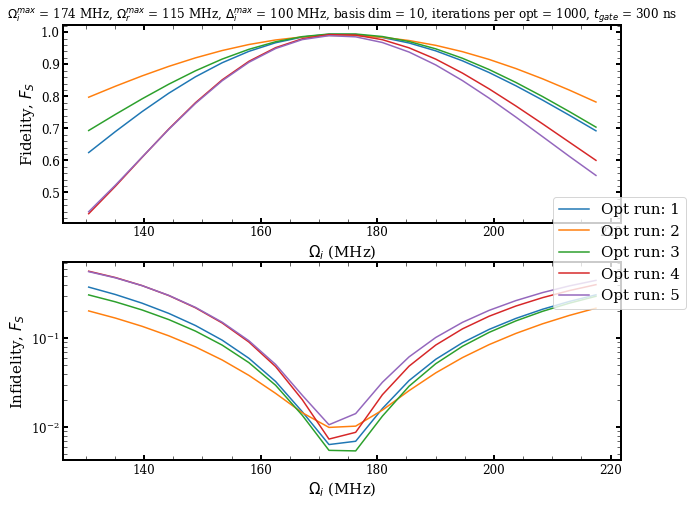

In [ ]:
# Set parameters: 

#Set number of basis functions for the control amplitudes
input_dim = 10 #(number of Gaussian modes)

#Set number of iterations in the optimization:
num_iters = 1000

#Set learn rate for optimizer:
learn_rate = 0.01

##Set time grid:
t_0 = 0 #Initial time
t_gate = 300 * ns #Final time of first 
nt = 1000 #number of time points
delta_t = (t_f - t_0)/nt #time difference between steps
tlist = np.linspace(0, t_f, nt)

##Define basis:
g_0, g_1, i, r, dark = nLevelAtomBasis(5) # basis are ground
psi0 = 1/2 * (tensor(g_0, g_0) + tensor(g_0, g_1) + \
              tensor(g_1, g_0) + tensor(g_1, g_1))
psi_targ = 1/2 * (tensor(g_0, g_0) + tensor(g_0, g_1) + \
              tensor(g_1, g_0) - tensor(g_1, g_1))

######Parameters level :######################
##Set system parameters: (from chapter 7 DeLeseleuc)
Rabi_i = 2*np.pi * 174 * MHz #coupling state 1 to i
Rabi_r = 2*np.pi * 115 * MHz #coupling state i to r

##Set detunings
del_total = 0
Delta_i = 2*np.pi * 100 * MHz  #Max detuning

#Set interaction strength:
V_int = 2 * np.pi * 24 * MHz #From Omran paper

#Set Rabi fluctuations:
Rabi_i_fluc = np.linspace(0.75, 1.25, 20) 
Rabi_i_plot = Rabi_i * Rabi_i_fluc

#Measure run time:
start = time.time()
count = 1

#set number of optimization runs:
num_runs = 5

Fidelity_Rabi_i = np.zeros([num_runs, len(Rabi_i_fluc)])
TF_infidelity_Rabi_i_list = np.zeros([num_runs, len(Rabi_i_fluc)])

ind_run = 0
for num_opts in range(num_runs):

    #Optimize pulse shapes
    physical_amplitudes_final, TF_infidelity_opt = Optimize_pulse(t_gate, num_iters)
    Rabi_r_Pulse_real_opt = physical_amplitudes_final[:,3] * \
                          np.cos(np.pi * physical_amplitudes_final[:,4])
    Rabi_r_Pulse_opt_real_S = Cubic_Spline(tlist[0], tlist[-1], Rabi_r_Pulse_real_opt)
    Rabi_r_Pulse_imag_opt = physical_amplitudes_final[:,3] * \
                      np.sin(np.pi * physical_amplitudes_final[:,4])
    Rabi_r_Pulse_opt_imag_S = Cubic_Spline(tlist[0], tlist[-1], Rabi_r_Pulse_imag_opt)

    Delta_i_opt = physical_amplitudes_final[:,0]
    Delta_i_opt_S = Cubic_Spline(tlist[0], tlist[-1], Delta_i_opt)

    ind_rabi = 0
    for Rabi_i_max in Rabi_i_fluc:

        #Test robustness:
        #Set actual pulse amplitudes (tanh(ctrl_amplitudes))
        Rabi_i_Pulse_real_opt = Rabi_i_max * physical_amplitudes_final[:,1] * \
                          np.cos(np.pi * physical_amplitudes_final[:,2])
        Rabi_i_Pulse_opt_real_S = Cubic_Spline(tlist[0], tlist[-1], Rabi_i_Pulse_real_opt) #interpolated data for time evolution
        Rabi_i_Pulse_imag_opt = Rabi_i_max * physical_amplitudes_final[:,1] * \
                          np.sin(np.pi * physical_amplitudes_final[:,2])
        Rabi_i_Pulse_opt_imag_S = Cubic_Spline(tlist[0], tlist[-1], Rabi_i_Pulse_imag_opt) #interpolated data for time evolution

        #Convert real and imaginary parts of Rabi frequency into amplitude and phase
        Rabi_i_amplitude = np.sqrt(Rabi_i_Pulse_opt_real_S(tlist)**2 + Rabi_i_Pulse_opt_imag_S(tlist)**2)
        Rabi_i_phase = np.pi * physical_amplitudes_final[:,2]
        Rabi_r_amplitude = np.sqrt(Rabi_r_Pulse_opt_real_S(tlist)**2 + Rabi_r_Pulse_opt_imag_S(tlist)**2)
        Rabi_r_phase = np.pi * physical_amplitudes_final[:,4]

        #Set parameters for Hamiltonian
        argsME5lvl = [psi0, psi_targ, Rabi_i, Rabi_r,
                      Rabi_i_Pulse_opt_real_S, Rabi_r_Pulse_opt_real_S,
                      Rabi_i_Pulse_opt_imag_S, Rabi_r_Pulse_opt_imag_S,
                      Delta_i_opt_S, Delta_i, del_total, Gamma_i1, Gamma_i0, Gamma_10
                ]

        # #Solve Propagator Equation: Superoperator
        result = Mesolve_5lvl_t(tlist, argsME5lvl)

        rho_0_t = result.expect[0]
        rho_orth_t = result.expect[1]
        rho_i_t = result.expect[2]
        rho_rr_t = result.expect[3]

        Fidelity_Rabi_i[ind_run, ind_rabi] = rho_orth_t[-1]
        TF_infidelity_Rabi_i_list[ind_run, ind_rabi] = TF_infidelity_opt 

        ind_rabi += 1
    #Measure run time:
    end_temp = time.time()
    print('Run Time: %2.4f minutes (%.0f out of %.0f opts)'
        %((end_temp-start)/60, count,
        num_runs)
    ) 
    
    count += 1
    ind_run += 1  

#plot Rabi freq vs fidelity
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,8))

for ind_plot in range(num_runs):
    ax1.plot(Rabi_i_plot/(2*np.pi*MHz), Fidelity_Rabi_i[ind_plot],
             label = r'Opt run: %.0f' %(ind_plot + 1)
    )
    ax2.semilogy(Rabi_i_plot/(2*np.pi*MHz), 1 - Fidelity_Rabi_i[ind_plot]
    )

ax1.set_xlabel(r'$\Omega_i$ (MHz)');
ax2.set_xlabel(r'$\Omega_i$ (MHz)');
ax1.set_ylabel(r'Fidelity, $F_S$');
ax2.set_ylabel(r'Infidelity, $F_S$');

ax1.set_title(
    '$\Omega_i^{max}$ = %0.f MHz, $\Omega_r^{max}$ = %.0f MHz, $\Delta_i^{max}$ = %.0f MHz, \
basis dim = %.0f, iterations per opt = %.0f, $t_{gate}$ = %.0f ns'

%(Rabi_i/(2 * np.pi * MHz), Rabi_r/(2 * np.pi * MHz), Delta_i/(2 * np.pi * MHz),
  input_dim, num_iters, t_gate/ns
  ), fontsize = 12
)
fig.legend(loc = 'center right')


# Robustness: Detuning
-frequency fluctuations


Run Time: 7.0368 minutes (1 out of 5 opts)


Run Time: 14.1219 minutes (2 out of 5 opts)


Run Time: 21.0528 minutes (3 out of 5 opts)


Run Time: 28.0422 minutes (4 out of 5 opts)


Run Time: 35.0049 minutes (5 out of 5 opts)


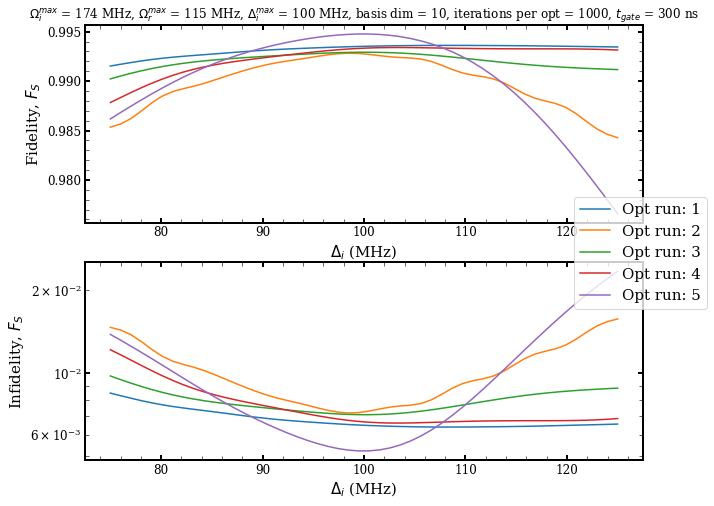

In [ ]:
# Set parameters: 

#Set number of basis functions for the control amplitudes
input_dim = 10 #(number of Gaussian modes)

#Set number of iterations in the optimization:
num_iters = 1000

#Set learn rate for optimizer:
learn_rate = 0.01

##Set time grid:
t_0 = 0 #Initial time
t_gate = 300 * ns #Final time of first 
nt = 1000 #number of time points
delta_t = (t_f - t_0)/nt #time difference between steps
tlist = np.linspace(0, t_f, nt)

##Define basis:
g_0, g_1, i, r, dark = nLevelAtomBasis(5) # basis are ground
psi0 = 1/2 * (tensor(g_0, g_0) + tensor(g_0, g_1) + \
              tensor(g_1, g_0) + tensor(g_1, g_1))
psi_targ = 1/2 * (tensor(g_0, g_0) + tensor(g_0, g_1) + \
              tensor(g_1, g_0) - tensor(g_1, g_1))

######Parameters level :######################
##Set system parameters: (from chapter 7 DeLeseleuc)
Rabi_i = 2*np.pi * 174 * MHz #coupling state 1 to i
Rabi_r = 2*np.pi * 115 * MHz #coupling state i to r

##Set detunings
del_total = 0
Delta_i = 2*np.pi * 100 * MHz  #Max detuning

#Set interaction strength:
V_int = 2 * np.pi * 24 * MHz #From Omran paper

#Set Rabi fluctuations:
Delta_i_fluc = np.linspace(0.75, 1.25, 50) 
Delta_i_plot = Delta_i * Delta_i_fluc

#Measure run time:
start = time.time()
count = 1

#set number of optimization runs:
num_runs = 5

Fidelity_Delta_i = np.zeros([num_runs, len(Delta_i_fluc)])
TF_infidelity_Delta_i_list = np.zeros([num_runs, len(Delta_i_fluc)])

ind_run = 0
for num_opts in range(num_runs):

    #Optimize pulse shapes
    physical_amplitudes_final, TF_infidelity_opt = Optimize_pulse(t_gate, num_iters)
    
    #Set actual pulse amplitudes (tanh(ctrl_amplitudes))
    Rabi_i_Pulse_real_opt = physical_amplitudes_final[:,1] * \
                      np.cos(np.pi * physical_amplitudes_final[:,2])
    Rabi_i_Pulse_opt_real_S = Cubic_Spline(tlist[0], tlist[-1], Rabi_i_Pulse_real_opt) #interpolated data for time evolution
    Rabi_i_Pulse_imag_opt = physical_amplitudes_final[:,1] * \
                      np.sin(np.pi * physical_amplitudes_final[:,2])
    Rabi_i_Pulse_opt_imag_S = Cubic_Spline(tlist[0], tlist[-1], Rabi_i_Pulse_imag_opt) #interpolated data for time evolution

    Rabi_r_Pulse_real_opt = physical_amplitudes_final[:,3] * \
                      np.cos(np.pi * physical_amplitudes_final[:,4])
    Rabi_r_Pulse_opt_real_S = Cubic_Spline(tlist[0], tlist[-1], Rabi_r_Pulse_real_opt)
    Rabi_r_Pulse_imag_opt = physical_amplitudes_final[:,3] * \
                      np.sin(np.pi * physical_amplitudes_final[:,4])
    Rabi_r_Pulse_opt_imag_S = Cubic_Spline(tlist[0], tlist[-1], Rabi_r_Pulse_imag_opt)
    
    #Convert real and imaginary parts of Rabi frequency into amplitude and phase
    Rabi_i_amplitude = np.sqrt(Rabi_i_Pulse_opt_real_S(tlist)**2 + Rabi_i_Pulse_opt_imag_S(tlist)**2)
    Rabi_i_phase = np.pi * physical_amplitudes_final[:,2]
    Rabi_r_amplitude = np.sqrt(Rabi_r_Pulse_opt_real_S(tlist)**2 + Rabi_r_Pulse_opt_imag_S(tlist)**2)
    Rabi_r_phase = np.pi * physical_amplitudes_final[:,4]

    ind_delta = 0
    for Delta_i_max in Delta_i_fluc:

        #Test robustness:
        Delta_i_opt = Delta_i_max * physical_amplitudes_final[:,0]
        Delta_i_opt_S = Cubic_Spline(tlist[0], tlist[-1], Delta_i_opt)



        #Set parameters for Hamiltonian
        argsME5lvl = [psi0, psi_targ, Rabi_i, Rabi_r,
                      Rabi_i_Pulse_opt_real_S, Rabi_r_Pulse_opt_real_S,
                      Rabi_i_Pulse_opt_imag_S, Rabi_r_Pulse_opt_imag_S,
                      Delta_i_opt_S, Delta_i, del_total, Gamma_i1, Gamma_i0, Gamma_10
                ]

        # #Solve Propagator Equation: Superoperator
        result = Mesolve_5lvl_t(tlist, argsME5lvl)

        rho_0_t = result.expect[0]
        rho_orth_t = result.expect[1]
        rho_i_t = result.expect[2]
        rho_rr_t = result.expect[3]

        Fidelity_Delta_i[ind_run, ind_delta] = rho_orth_t[-1]
        TF_infidelity_Delta_i_list[ind_run, ind_delta] = TF_infidelity_opt 

        ind_delta += 1
    #Measure run time:
    end_temp = time.time()
    print('Run Time: %2.4f minutes (%.0f out of %.0f opts)'
        %((end_temp-start)/60, count,
        num_runs)
    ) 
    
    count += 1
    ind_run += 1  

#plot Rabi freq vs fidelity
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,8))

for ind_plot in range(num_runs):
    ax1.plot(Delta_i_plot/(2*np.pi*MHz), Fidelity_Delta_i[ind_plot],
             label = r'Opt run: %.0f' %(ind_plot + 1)
    )
    ax2.semilogy(Delta_i_plot/(2*np.pi*MHz), 1 - Fidelity_Delta_i[ind_plot]
    )

ax1.set_xlabel(r'$\Delta_i$ (MHz)');
ax2.set_xlabel(r'$\Delta_i$ (MHz)');
ax1.set_ylabel(r'Fidelity, $F_S$');
ax2.set_ylabel(r'Infidelity, $F_S$');

ax1.set_title(
    '$\Omega_i^{max}$ = %0.f MHz, $\Omega_r^{max}$ = %.0f MHz, $\Delta_i^{max}$ = %.0f MHz, \
basis dim = %.0f, iterations per opt = %.0f, $t_{gate}$ = %.0f ns'

%(Rabi_i/(2 * np.pi * MHz), Rabi_r/(2 * np.pi * MHz), Delta_i/(2 * np.pi * MHz),
  input_dim, num_iters, t_gate/ns
  ), fontsize = 12
)
fig.legend(loc = 'center right')
